In [79]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [80]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [81]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [95]:
def calculate_reversal_factor(df, window=96, quantile=0.6825):
    """
    计算基于高分位切割的反转因子（M_high_13/16）
    
    步骤：
    1. 计算平均单笔成交金额 D = turnover / trade_count
    2. 计算每根K线的收益率 return = (close - open) / open
    3. 计算过去N根K线的指定分位值（默认为13/16=0.8125）
    4. 根据分位值将K线分为高分组和低分组
    5. 高分组收益率和 - 低分组收益率和 作为因子值
    
    参数:
    df: 包含OHLCV数据的DataFrame
    window: 回溯窗口大小（默认20根K线）
    quantile: 切割分位值（13/16=0.8125）
    """
    # 计算平均单笔成交金额
    df['D'] = df['turnover'] / df['trade_count']
    
    # 计算每根K线的收益率
    df['return'] = (df['close'] - df['open']) / df['open']
    
    # 初始化因子值列
    factor_values = np.full(len(df), np.nan)
    
    # 计算指定分位值
    quantile_values = df['D'].rolling(window=window).quantile(quantile)
    
    # 计算因子值
    for i in range(window, len(df)):
        # 获取当前窗口数据
        window_data = df.iloc[i-window:i]
        
        # 根据分位值切割分组
        high_group = window_data[window_data['D'] > quantile_values.iloc[i]]
        low_group = window_data[window_data['D'] <= quantile_values.iloc[i]]
        
        # 计算各组收益率和
        M_high = high_group['return'].sum()
        M_low = low_group['return'].sum()
        
        # 因子值 = 高分组收益率和 - 低分组收益率和
        factor_values[i] = M_high - M_low
    
    return factor_values

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.008360
   Rank_IC (Spearman): -0.025845
📊 信息比率:
   IR: -0.314838
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130800
   因子列: reversal_factor_13_16
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


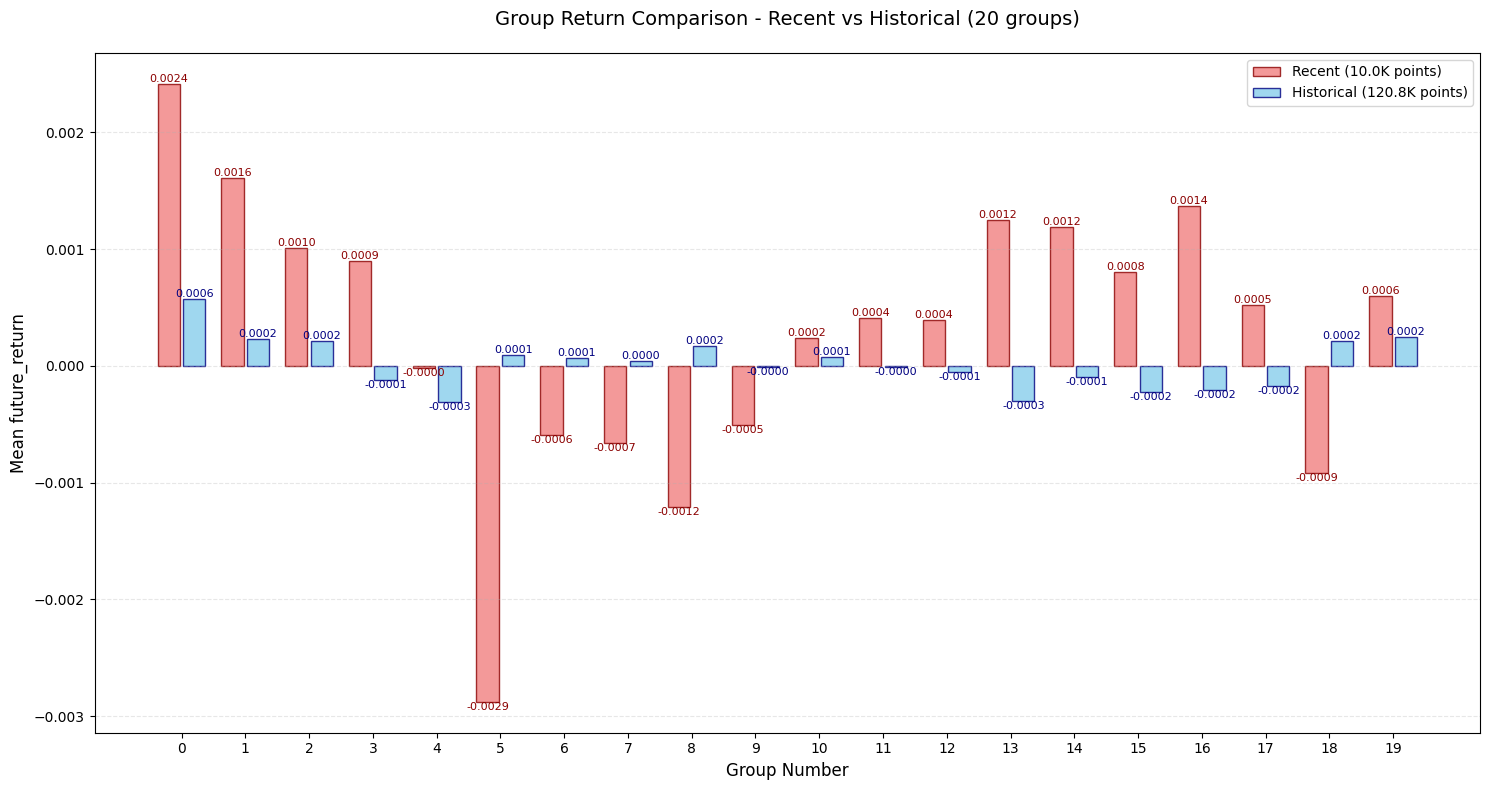

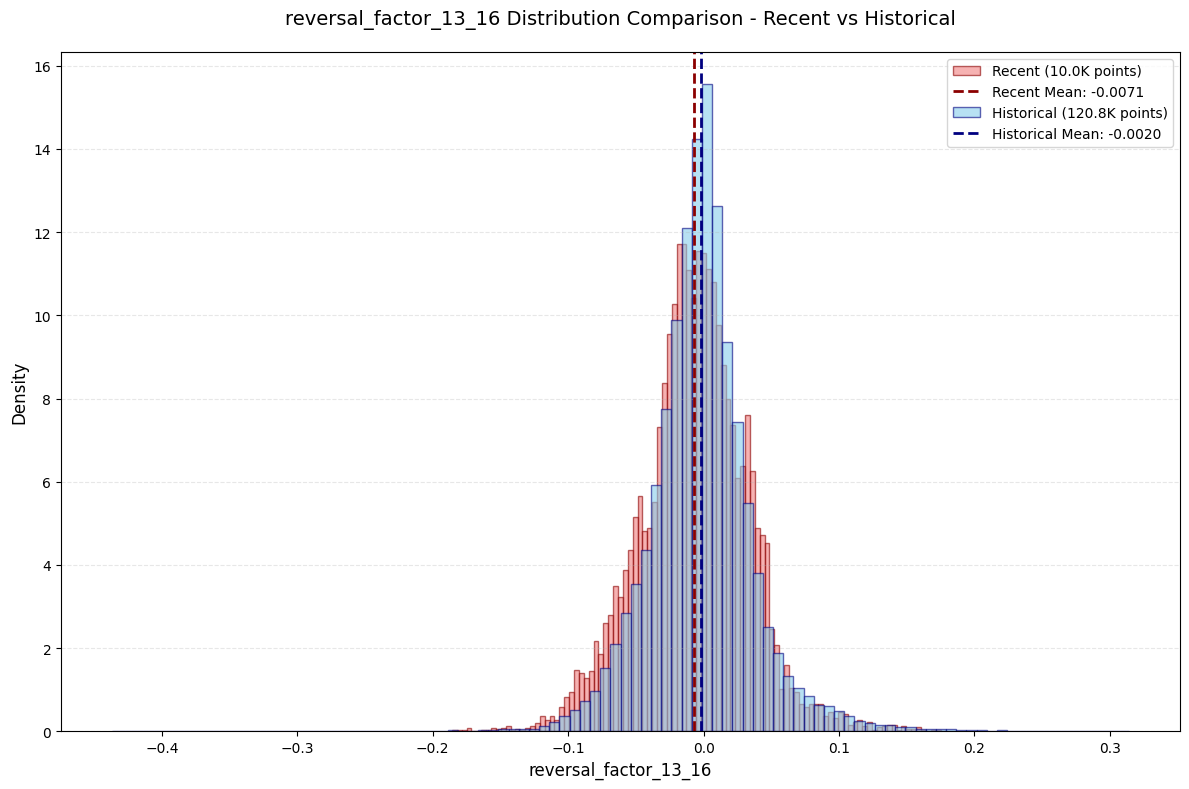

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [96]:
evaluator.set_factor(
    factor_func=lambda df: calculate_reversal_factor(df),
    factor_name='reversal_factor_13_16'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

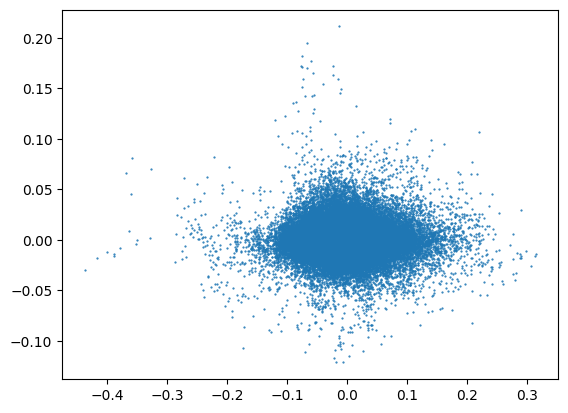

In [97]:
import matplotlib.pyplot as plt
plt.scatter(calculate_reversal_factor(df),df['close'].pct_change(-10), s=0.3)

In [98]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.04864415314311608,
 -0.014841993688109362,
 0.018550097665012328,
 -0.007458990792719744,
 -0.007750675022286564,
 -0.004312521627223614,
 -0.005724746926488519,
 -0.007030895349042785,
 0.0025844811968728856,
 0.018483540299407644]

In [99]:
print(result)

{'correlation_analysis': {'IC': -0.008359820872529958, 'Rank_IC': -0.02584520163506528}, 'information_ratio': {'IR': -0.3148382962041472, 'group_correlations': [-0.04864415314311608, -0.014841993688109362, 0.018550097665012328, -0.007458990792719744, -0.007750675022286564, -0.004312521627223614, -0.005724746926488519, -0.007030895349042785, 0.0025844811968728856, 0.018483540299407644], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -0.4369  -0.0640   -0.0880       0.0008      0.0168   6540
1      -0.0640  -0.0476   -0.0551       0.0003      0.0140   6540
2      -0.0476  -0.0366   -0.0418       0.0002      0.0126   6540
3      -0.0366  -0.0289   -0.0326      -0.0001      0.0112   6540
4      -0.0289  -0.0229   -0.0258      -0.0006      0.0113   6540
5      -0.0229  -0.0178   -0.0203       0.0001      0.0113   6540
6      -0.0178  -0.0134   -0.015